# LIDC

# CNN - DenseNet 3D

In [1]:
import os
import pandas as pd
import numpy as np
import time
import random
import cv2
import pydicom
import SimpleITK as sitk

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import defaultdict


from sklearn.model_selection import train_test_split
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image

from monai.transforms import (
    Compose, Resize, LoadImaged, RepeatChanneld, ScaleIntensity, ResizeWithPadOrCropd, ToTensord,
    RandGaussianNoise, RandAdjustContrast, RandGaussianSmooth, Rand3DElasticd, RandBiasField, 
    RandCropByPosNegLabeld, Resized, RandFlip, RandAffine, Compose, Resize
)

from torch.amp import autocast, GradScaler
from monai.data import DataLoader, Dataset
from collections import Counter
from torchvision import models
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset, WeightedRandomSampler
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve


## Checking if Gpu were recognized

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("PyTorch is using GPU!")
    print(torch.cuda.get_device_name(0)) #prints the name of the GPU.
else:
    device = torch.device("cpu")
    print("PyTorch is using CPU.")

PyTorch is using GPU!
NVIDIA RTX A6000


# Constants

In [14]:
IMAGE_SIZE = (512, 512, 512)
BATCH_SIZE = 1
NUM_CHANNELS = 1
DEPTH = 256
NUM_CLASSES = 2
PATIENCE_COUNTER = 5
EPOCHS = 50
SEED = 42
VAL_RATIO = 0.2
TEST_RATIO = 0.2

DICOM_DIR = "/home/etudiant/Projets/Viviane/LIDC-ML/data/LIDC_classes_dcm"
PATH_MODEL = '/home/etudiant/Projets/Viviane/LIDC-ML/models/best_model_densenet3D.pth'
CLASS_MAP = {'cancer': 0, 'non-cancer': 1}
INDEX_TO_CLASS = {0: 'non-cancer', 1: 'cancer'}

AUG_PER_CLASS = {"train": 0, "val": 0, "test": 0}

IMAGE_SIZE_SUMMARY = 512


# Preprocessing

In [30]:
# Set seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)

In [29]:
def resize_volume(volume, target_shape):
    resize = Resize(spatial_size=target_shape, mode="trilinear")
    resized = resize(volume)
    if isinstance(resized, np.ndarray):
        return resized
    elif hasattr(resized, "numpy"):
        return resized.numpy()
    else:
        return np.asarray(resized)

def normalize_volume(volume):
    volume = np.clip(volume, -1000, 400)
    min_val = np.min(volume)
    max_val = np.max(volume)
    if max_val - min_val > 0:
        volume = (volume - min_val) / (max_val - min_val)
    else:
        volume = np.zeros_like(volume)
    return volume.astype(np.float32)

In [28]:
# Helper: Load and preprocess a 3D volume from a list of DICOM paths
def load_dicom_volume(dcm_paths, target_size=IMAGE_SIZE, min_slices=3):
    slices = []
    for path in dcm_paths:
        try:
            ds = pydicom.dcmread(path, stop_before_pixels=False)
            if hasattr(ds, 'InstanceNumber'):
                slices.append((ds.InstanceNumber, path))
        except Exception:
            print(f"DICOM read failed: {path} | {e}")
            continue

    if len(slices) < min_slices:
        return None

    slices.sort(key=lambda x: x[0])
    sorted_paths = [p for _, p in slices]

    volume = []
    for path in sorted_paths:
        try:
            img = sitk.ReadImage(path)
            array = sitk.GetArrayFromImage(img)[0]  # (H, W)
            expected_shape = (512, 512) # This is the expected shape form he dicom images, because there is different shapes that don`t correspond the right folder`
            if array.shape == expected_shape:  
                volume.append(array)
        except Exception as e:
            # print(f"Slice read failed in {path}: {e}")
            continue

    if len(volume) < min_slices:
        return None
    
    volume = np.stack(volume, axis=0)  # (D, H, W)
    volume = np.transpose(volume, (1, 2, 0))  # (H, W, D)
    volume = normalize_volume(volume)
        
    volume = np.expand_dims(volume, axis = 0)  # Add channel for Resize
    volume = resize_volume(volume, target_size)
    # volume = volume[0]  # Remove channel dim
    return volume.astype(np.float32)


In [20]:
# Helper: Build patient-to-path mapping
def build_patient_dict(base_dir):
    class_dict = {"cancer": {}, "non-cancer": {}}
    for cls in ["cancer", "non-cancer"]:
        cls_path = os.path.join(base_dir, cls)
        for root, _, files in os.walk(cls_path):
            for fname in files:
                if fname.endswith(".dcm"):
                    pid = fname.split("_")[0]
                    if pid not in class_dict[cls]:
                        class_dict[cls][pid] = []
                    class_dict[cls][pid].append(os.path.join(root, fname))
    return class_dict

In [22]:
def split_data(class_dict):
    train, val, test = [], [], []
    for label_name, pid_dict in class_dict.items():
        label = 1 if label_name == "cancer" else 0
        pids = list(pid_dict.keys())
        train_p, test_p = train_test_split(pids, test_size=TEST_RATIO, random_state=SEED)
        train_p, val_p = train_test_split(train_p, test_size=VAL_RATIO / (1 - TEST_RATIO), random_state=SEED)

        for pid in train_p:
            train.append((pid_dict[pid], label))
        for pid in val_p:
            val.append((pid_dict[pid], label))
        for pid in test_p:
            test.append((pid_dict[pid], label))

    return train, val, test

# Loading Dataset

In [24]:
class LIDCDataset3D(Dataset):
    def __init__(self, data_list, label_map, transform=None):
        self.data_list = data_list  # [(paths, label), ...]
        self.label_map = label_map
        self.transform = transform

        self.class_to_idx = {0: "non-cancer", 1: "cancer"}

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        paths, label = self.data_list[idx]
        vol = load_dicom_volume(paths)
        if vol is None:
            return self.__getitem__((idx + 1) % len(self))  # fallback
        vol = torch.tensor(vol)
        if self.transform:
            vol = self.transform(vol)
        return vol, torch.tensor(label, dtype=torch.float32)


In [25]:
def get_transforms():
    return Compose([
        RandFlip(spatial_axis=0, prob=0.5),
        RandFlip(spatial_axis=1, prob=0.5),
        RandFlip(spatial_axis=2, prob=0.5),
        RandAffine(
            rotate_range=(0.1, 0.1, 0.1),
            translate_range=(5, 5, 5),
            scale_range=(0.1, 0.1, 0.1),
            prob=0.3
        ),
        RandBiasField(prob=0.3),
        RandGaussianNoise(prob=0.2, mean=0, std=0.01),
        RandAdjustContrast(prob=0.3, gamma=(0.7, 1.5)),
        RandGaussianSmooth(prob=0.3),
        Resize(spatial_size=IMAGE_SIZE, mode="trilinear")
    ])

In [26]:
class_dict = build_patient_dict(DICOM_DIR)
train_data, val_data, test_data = split_data(class_dict)

train_dataset = LIDCDataset3D(train_data, label_map={"cancer": 1, "non-cancer": 0}, transform=get_transforms())
val_dataset = LIDCDataset3D(val_data, label_map={"cancer": 1, "non-cancer": 0}, transform=get_transforms())
test_dataset = LIDCDataset3D(test_data, label_map={"cancer": 1, "non-cancer": 0}, transform=get_transforms())

print(f"✅ Loaded: {len(train_dataset)} train | {len(val_dataset)} val | {len(test_dataset)} test")


✅ Loaded: 93 train | 32 val | 32 test


### Weighted Sampler

In [49]:
labels_train = [s[1] for s in train_dataset.data_list]  # Adjust if your dataset is not structured this way

class_sample_count = np.bincount(labels_train)
weights = 1. / class_sample_count
samples_weight = [weights[label_] for label_ in labels_train]
sampler_train = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, sampler=sampler_train)

In [13]:
labels_val = [s[1] for s in val_dataset.data_list]  # Adjust if your dataset is not structured this way

class_sample_count = np.bincount(labels_val)
weights = 1. / class_sample_count
samples_weight = [weights[label_] for label_ in labels_val]
sampler_val = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

val_loader = DataLoader(val_dataset, batch_size=1, num_workers=0, sampler=sampler_val)

In [14]:
labels_test = [s[1] for s in val_dataset.data_list] 

class_sample_count = np.bincount(labels_test)
weights = 1. / class_sample_count
samples_weight = [weights[label_] for label_ in labels_test]
sampler_test = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, sampler=sampler_test)

### Size by classes in Train dataset

In [15]:
classes = [cls for cls in train_dataset.class_to_idx.values()]

In [16]:
# Collect labels from your dataset
labels = [int(label) for _, label in train_dataset.data_list]

# Count occurrences
label_counts = Counter(labels)

# Define your index-to-class mapping manually if needed
index_to_class = INDEX_TO_CLASS  # adjust if different

# Print counts
print("\nTraining set counts:")
for idx, count in label_counts.items():
    print(f"Class: {index_to_class[idx]}, Count: {count}")


Training set counts:
Class: cancer, Count: 56
Class: non-cancer, Count: 37


In [33]:
# Collect labels from your dataset
labels = [int(label) for _, label in test_dataset.data_list]

# Count occurrences
label_counts = Counter(labels)

# Define your index-to-class mapping manually if needed
index_to_class = INDEX_TO_CLASS  # adjust if different

# Print counts
print("\nTraining set counts:")
for idx, count in label_counts.items():
    print(f"Class: {index_to_class[idx]}, Count: {count}")


Training set counts:
Class: cancer, Count: 19
Class: non-cancer, Count: 13


In [46]:
labels[19]

0

# Architecture

In [9]:
from monai.networks.nets import DenseNet121

class DenseNet3DClassifier(torch.nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(DenseNet3DClassifier, self).__init__()
        self.model = DenseNet121(
            spatial_dims=3,
            in_channels=in_channels,
            out_channels=out_channels,
        )

    def forward(self, x):
        return self.model(x)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DenseNet3DClassifier(in_channels=1, out_channels=1)  # Binary classification
model = model.to(device)  # If using GPU

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [19]:
for name, module in model.named_modules():
    print(name, ":", module)

 : DenseNet3DClassifier(
  (model): DenseNet121(
    (features): Sequential(
      (conv0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
      (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (layers): Sequential(
            (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
       

In [20]:
summary(model, input_size=(BATCH_SIZE, NUM_CHANNELS, DEPTH, IMAGE_SIZE_SUMMARY, IMAGE_SIZE_SUMMARY))

Layer (type:depth-idx)                             Output Shape              Param #
DenseNet3DClassifier                               [1, 1]                    --
├─DenseNet121: 1-1                                 [1, 1]                    --
│    └─Sequential: 2-1                             [1, 1024, 8, 16, 16]      --
│    │    └─Conv3d: 3-1                            [1, 64, 128, 256, 256]    21,952
│    │    └─BatchNorm3d: 3-2                       [1, 64, 128, 256, 256]    128
│    │    └─ReLU: 3-3                              [1, 64, 128, 256, 256]    --
│    │    └─MaxPool3d: 3-4                         [1, 64, 64, 128, 128]     --
│    │    └─_DenseBlock: 3-5                       [1, 256, 64, 128, 128]    777,408
│    │    └─_Transition: 3-6                       [1, 128, 32, 64, 64]      33,280
│    │    └─_DenseBlock: 3-7                       [1, 512, 32, 64, 64]      1,804,416
│    │    └─_Transition: 3-8                       [1, 256, 16, 32, 32]      132,096
│    │   

# Trainning

Sampled label distribution from WeightedRandomSampler:
Class 0: 40 samples
Class 1: 53 samples


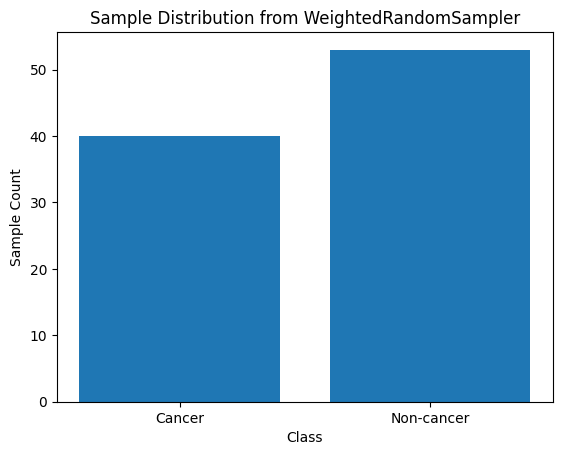

In [50]:
from collections import Counter
import matplotlib.pyplot as plt

# Collect labels from one full pass through the train_loader
sampled_labels = []

for i, (img, label) in enumerate(train_loader):
    sampled_labels.extend(label.cpu().numpy().astype(int))  # Convert to int (0 or 1)
    if i >= len(train_loader):  # Only loop once through the loader
        break

# Count label occurrences
label_counts = Counter(sampled_labels)

# Print result
print("Sampled label distribution from WeightedRandomSampler:")
for label in sorted(label_counts.keys()):
    print(f"Class {label}: {label_counts[label]} samples")

# Optional: plot
plt.bar(label_counts.keys(), label_counts.values(), tick_label=["Non-cancer", "Cancer"])
plt.xlabel("Class")
plt.ylabel("Sample Count")
plt.title("Sample Distribution from WeightedRandomSampler")
plt.show()

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, num_classes, patience, path_model):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Metrics
    confusion_matrix = MulticlassConfusionMatrix(num_classes=num_classes)
    precision = MulticlassPrecision(num_classes=num_classes, average='macro')
    recall = MulticlassRecall(num_classes=num_classes, average='macro')
    f1_score = MulticlassF1Score(num_classes=num_classes, average='macro')

    # Early stopping parameters
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = path_model

    scaler = GradScaler("cuda")

    # --- Gradient Accumulation Parameter ---
    # Set your desired effective batch size here.
    # For example, if your DataLoader's batch_size is 1 and you want an effective batch size of 4,
    # set accumulation_steps = 4.
    # physical_batch_size = train_loader.batch_size # Get this from your DataLoader
    # if physical_batch_size is None: # Handle cases where batch_size might be 1 by default (no explicit arg)
    #     physical_batch_size = 1
    # effective_batch_size = 4 # Or 8, 16, etc.
    # accumulation_steps = effective_batch_size // physical_batch_size
    # if accumulation_steps == 0: accumulation_steps = 1 # Ensure at least 1 step if effective_batch_size < physical_batch_size

    # A simpler way: just define the number of steps directly
    accumulation_steps = 4 # Example: Accumulate gradients over 4 mini-batches

    print(f"Using Gradient Accumulation with {accumulation_steps} steps.")
    print(f"DataLoader batch size: {train_loader.batch_size}")
    print(f"Effective batch size: {train_loader.batch_size * accumulation_steps if train_loader.batch_size else 'N/A (check DataLoader)'}") # Added check for None batch_size

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        confusion_matrix.reset()
        precision.reset()
        recall.reset()
        f1_score.reset()

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            if epoch == 0 and batch_idx == 0:
                print(f"🔍 Debug - First training batch")
                print(f"Input image shape: {inputs.shape}")  # Should be [1, 1, 512, 512, 512] if using grayscale 3D volumes
                print(f"Label: {labels}")

            # Clear gradients
            # optimizer.zero_grad()

            with autocast("cuda"):
            # feed foward
                outputs = model(inputs)

                # Compute loss using cross entropy
                # Assuming your criterion is suitable for outputs and labels shapes
                # For BCEWithLogitsLoss with 2 classes, outputs might be [B, 1] and labels [B, 1] (float)
                # Or for CrossEntropyLoss, outputs [B, num_classes] and labels [B] (long)
                # Your current line labels = labels.float().unsqueeze(1) suggests binary classification and outputs are also [B,1]
                labels_for_loss = labels.float().unsqueeze(1) if labels.dim() == 1 else labels.float() # Ensure labels match output shape
                loss = criterion(outputs, labels_for_loss)
            
                # Compute loss using cross entropy
                # labels = labels.float().unsqueeze(1)  # shape [B] -> [B, 1]
                # loss = criterion(outputs, labels)
            
            
            scaler.scale(loss).backward() # Scale loss and perform backward pass  # backpropagation
            
            # --- Gradient Accumulation: Step optimizer and update scaler only after N steps ---
            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.step(optimizer)        # Unscale gradients and perform optimizer step
                scaler.update()               # Update the scaler for the next iteration
                optimizer.zero_grad()

            # backpropagation
            # loss.backward()

            # Update weights
            # optimizer.step()

            # Update results
            train_loss += loss.item()

            if num_classes > 1: # Multiclass
                _, preds = torch.max(outputs, 1)
            else: # Binary
                preds = (outputs > 0).long().squeeze(1)

            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        if (batch_idx + 1) % accumulation_steps != 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluation part to print metrics for each epoch
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast("cuda"):
                    outputs = model(inputs)
                    labels = labels.float().unsqueeze(1)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()


                if num_classes > 1:
                    _, preds = torch.max(outputs, 1)
                else:
                    preds = (outputs > 0).long().squeeze(1)

                    
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

                # For metrics
                all_preds.append(preds.cpu())
                all_labels.append(labels.long().cpu().squeeze(1))

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        
        # all_preds = torch.cat(all_preds)
        # all_labels = torch.cat(all_labels)

        all_preds = torch.cat(all_preds).view(-1)
        all_labels = torch.cat(all_labels).view(-1)

        
        precision_value = precision(all_preds, all_labels)
        recall_value = recall(all_preds, all_labels)
        f1_value = f1_score(all_preds, all_labels)
        conf_matrix = confusion_matrix(all_preds, all_labels)

        # all_preds_final = torch.as_tensor(all_preds, device=device)
        # all_labels_final = torch.as_tensor(all_labels, device=device)

        # precision_value = precision(all_preds_final, all_labels_final)
        # recall_value = recall(all_preds_final, all_labels_final)
        # f1_value = f1_score(all_preds_final, all_labels_final)
        # conf_matrix = confusion_matrix(all_preds_final, all_labels_final)

        
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}%")
        print(f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}%")
        print(f"Precision: {precision_value:.4f} | Recall: {recall_value:.4f} | F1 Score: {f1_value:.4f}")
        print(f"Current AMP scale: {scaler.get_scale()}\n")
        
        # --- Early Stopping Logic ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 # Reset patience counter
            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'confusion_matrix': conf_matrix.cpu().numpy(), # Save the confusion matrix of the best model
                'scaler_state_dict': scaler.state_dict()
                }, best_model_path)
            print(f"Validation loss improved. Saving best model to {best_model_path}\n")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}\n")

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss for {patience} consecutive epochs.\n")
            break # Exit the training loop

    print("\nTraining complete.")
    # Load the best model after training is complete (either by early stopping or max epochs)
    print(f"Loading best model from {best_model_path} for final metrics.")
    checkpoint = torch.load(best_model_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    # You might not need to load optimizer state if you're just doing inference or final evaluation
    # --- Optional: Load optimizer state if resuming training ---
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict']) # Load optimizer state if resuming
    # --- Handle scaler state dict loading ---
    if 'scaler_state_dict' in checkpoint: # Check if the key exists
        scaler.load_state_dict(checkpoint['scaler_state_dict']) # --- AMP: Load scaler state ---
    else:
        print("Warning: 'scaler_state_dict' not found in checkpoint. This may be an older model or AMP was not used.")    
    final_conf_matrix = checkpoint['confusion_matrix'] # Retrieve the confusion matrix of the best model

    return train_losses, val_losses, train_accuracies, val_accuracies, conf_matrix, final_conf_matrix

In [22]:
t1 = time.time()
print(f"Using device: {device}")
train_losses, val_losses, train_accuracies, val_accuracies, conf_matrix, final_conf_matrix = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS, num_classes=NUM_CLASSES, patience=PATIENCE_COUNTER, path_model=PATH_MODEL)

elapsed = time.time() - t1
hours, rem = divmod(elapsed, 3600)
minutes, seconds = divmod(rem, 60)

print(f"######## Training Finished in {int(hours)}h {int(minutes)}m {int(seconds)}s ###########")

Using device: cuda
Using Gradient Accumulation with 4 steps.
DataLoader batch size: 1
Effective batch size: 4
🔍 Debug - First training batch
Input image shape: torch.Size([1, 1, 512, 512, 512])
Label: tensor([1.], device='cuda:0')
Epoch 1/50
Train Loss: 0.7044 | Train Acc: 51.61%
Val Loss: 0.9517 | Val Acc: 46.88%
Precision: 0.2344 | Recall: 0.5000 | F1 Score: 0.3191
Current AMP scale: 65536.0

Validation loss improved. Saving best model to /home/etudiant/Projets/Viviane/LIDC-ML/models/best_model_densenet3D.pth

Epoch 2/50
Train Loss: 0.7022 | Train Acc: 48.39%
Val Loss: 0.7370 | Val Acc: 40.62%
Precision: 0.2031 | Recall: 0.5000 | F1 Score: 0.2889
Current AMP scale: 65536.0

Validation loss improved. Saving best model to /home/etudiant/Projets/Viviane/LIDC-ML/models/best_model_densenet3D.pth

Epoch 3/50
Train Loss: 0.6928 | Train Acc: 50.54%
Val Loss: 1.2870 | Val Acc: 50.00%
Precision: 0.2500 | Recall: 0.5000 | F1 Score: 0.3333
Current AMP scale: 65536.0

Validation loss did not impr

# Evaluating

### Accuracy

In [23]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)  # shape: [N, 1]
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        predicted = (probs > 0.5).long().squeeze()  # Threshold at 0.5, shape: [N]
        labels = labels.view(-1)  # Ensure shape match with predicted
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy on {total} images: {(correct / total) * 100:.2f}%')

Test Accuracy on 32 images: 46.88%


### Loss and Accuracy

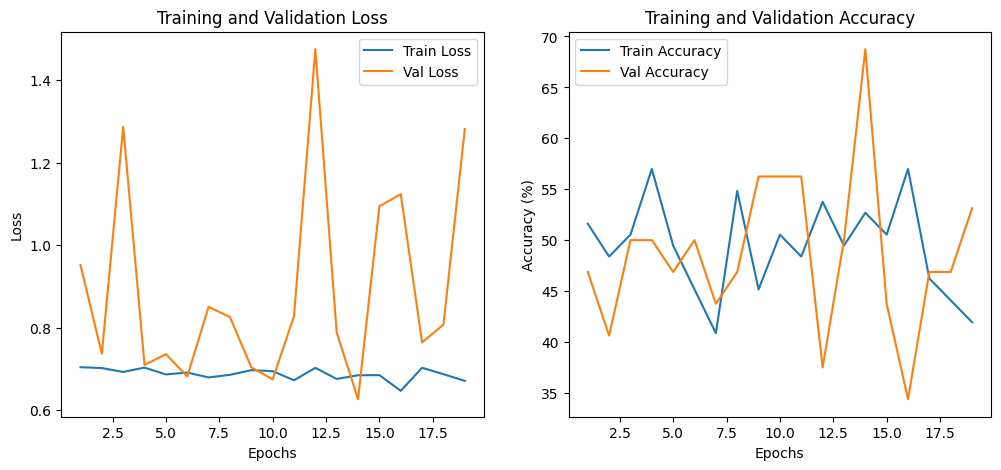

In [24]:
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

plot_training(train_losses, val_losses, train_accuracies, val_accuracies)

### Confusion Matrix

In [36]:
final_conf_matrix

array([[22,  0],
       [10,  0]])

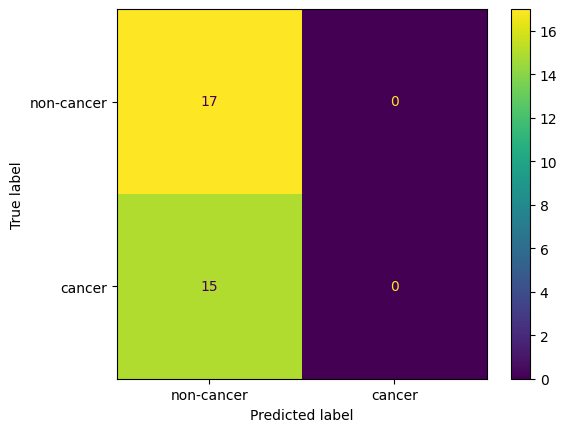

In [35]:
cm = conf_matrix.cpu().numpy()
disp = ConfusionMatrixDisplay(cm, display_labels=classes,)
disp.plot()

### AUC and ROC Curve

In [27]:
y_true = []
y_probs = []  # Collect probabilities for class 1 (cancer)

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:  # or test_loader
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)  # raw logits or softmax
        probs = torch.sigmoid(outputs)  # class 1 = cancer

        y_true.extend(labels.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

AUC: 0.5506


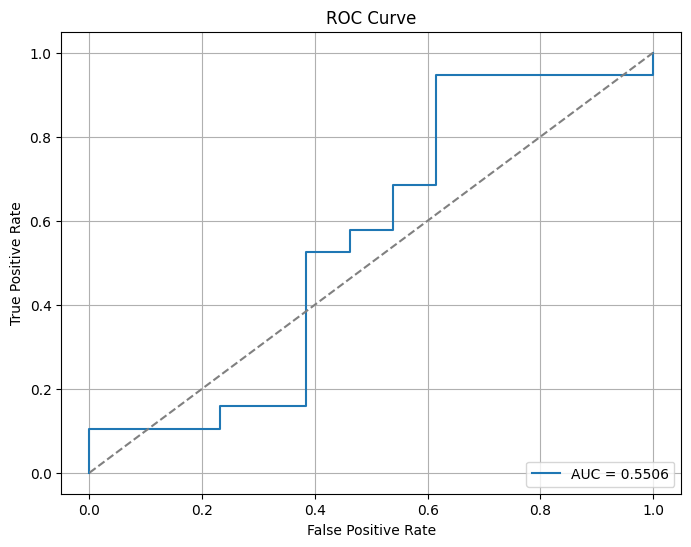

In [28]:
# Compute AUC
auc = roc_auc_score(y_true, y_probs)
print(f"AUC: {auc:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Metrics

In [29]:
precision = MulticlassPrecision(num_classes=NUM_CLASSES, average=None)
recall = MulticlassRecall(num_classes=NUM_CLASSES, average=None)
f1_score = MulticlassF1Score(num_classes=NUM_CLASSES, average=None)


all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())


all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)


per_class_precision = precision(all_preds, all_labels)
per_class_recall = recall(all_preds, all_labels)
per_class_f1 = f1_score(all_preds, all_labels)


for i, name in enumerate(classes):
    print(f"Class {i}-{name}: Precision: {per_class_precision[i]:.2f}, Recall: {per_class_recall[i]:.2f}, F1-Score: {per_class_f1[i]:.2f}")

Class 0-non-cancer: Precision: 0.31, Recall: 1.00, F1-Score: 0.48
Class 1-cancer: Precision: 0.00, Recall: 0.00, F1-Score: 0.00


In [30]:
# Save Model

In [31]:
torch.save(model.state_dict(), PATH_MODEL)

# GradCam

In [15]:
import torch
import torch.nn as nn
from monai.networks.nets import DenseNet121 # Assuming you're using MONAI's DenseNet121
import collections # For handling DataParallel state_dict if needed

# 1. Your model class definition (as provided)
class DenseNet3DClassifier(torch.nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(DenseNet3DClassifier, self).__init__()
        self.model = DenseNet121(
            spatial_dims=3,
            in_channels=in_channels,
            out_channels=out_channels,
        )

    def forward(self, x):
        return self.model(x)

# Define the path where your state_dict is saved
# PATH_MODEL = PATH_MODEL # <--- IMPORTANT: Replace with your actual path

# Define the input and output channels used during training
# These MUST match the values used when you trained and saved the model.
TRAINED_IN_CHANNELS = 1   # Example: for grayscale 3D images
TRAINED_OUT_CHANNELS = 1 # Example: for binary classification or a single output value

try:
    # 2. Instantiate your model class
    # Pass the SAME in_channels and out_channels that you used during training.
    model = DenseNet3DClassifier(in_channels=TRAINED_IN_CHANNELS, out_channels=TRAINED_OUT_CHANNELS)
    print(f"Instantiated DenseNet3DClassifier with in_channels={TRAINED_IN_CHANNELS}, out_channels={TRAINED_OUT_CHANNELS}")

    # 3. Load the state_dict
    state_dict = torch.load(PATH_MODEL)
    print(f"Loaded state_dict from {PATH_MODEL}")

    # *** IMPORTANT CHECK: Handle 'module.' prefix if you used nn.DataParallel for training ***
    # If your model was trained using `nn.DataParallel`, the keys in the state_dict
    # will have a 'module.' prefix (e.g., 'module.model.features.0.weight').
    # You need to remove this prefix when loading into a single-GPU/CPU model.
    if list(state_dict.keys())[0].startswith('module.'):
        print("Removing 'module.' prefix from state_dict keys for DataParallel compatibility...")
        new_state_dict = collections.OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove 'module.' prefix
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
    else:
        print("No 'module.' prefix found. Loading state_dict directly.")
        model.load_state_dict(state_dict)

    # 4. Set the model to evaluation mode
    model.eval()

    print("Model loaded successfully and set to evaluation mode.")

    # Now 'model' is a proper torch.nn.Module instance with loaded weights.
    # You can proceed with your Grad-CAM implementation.

except FileNotFoundError:
    print(f"Error: Model file not found at {PATH_MODEL}. Please double-check the path.")
except RuntimeError as e:
    print(f"Runtime Error during model loading (likely mismatch in model architecture or state_dict keys): {e}")
    print("Please ensure the `in_channels` and `out_channels` passed to DenseNet3DClassifier match what was used during training.")
    print("Also, confirm if the saved model was trained with `nn.DataParallel` (leading to 'module.' prefixes).")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Instantiated DenseNet3DClassifier with in_channels=1, out_channels=1
Loaded state_dict from /home/etudiant/Projets/Viviane/LIDC-ML/models/best_model_densenet3D.pth
No 'module.' prefix found. Loading state_dict directly.
Model loaded successfully and set to evaluation mode.


In [16]:
def replace_relu_with_non_inplace(module):
    for name, child in module.named_children():
        if isinstance(child, torch.nn.ReLU) and child.inplace:
            setattr(module, name, torch.nn.ReLU(inplace=False))
        else:
            replace_relu_with_non_inplace(child)

replace_relu_with_non_inplace(model)

In [17]:
import scipy.ndimage

class GradCAM3D:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            print("Backward hook triggered")
            self.gradients = grad_out[0].detach().clone()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class=None):
        input_tensor = input_tensor.unsqueeze(0)  # Add batch dim if missing
        input_tensor = input_tensor.to(next(self.model.parameters()).device)
        input_tensor.requires_grad = True

        self.model.zero_grad()
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output)

        loss = output[0, target_class]
        loss.backward()

        if self.gradients is None:
            raise RuntimeError("Backward hook did not capture gradients.")

        weights = torch.mean(self.gradients, dim=[2, 3, 4], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().detach().numpy()

        return cam, target_class

    def visualize(self, image_tensor, cam):
    

        image_np = image_tensor.squeeze().cpu().numpy()
        cam_np = cam  # Already a NumPy array

        # Resize CAM to match input shape
        cam_resized = scipy.ndimage.zoom(
            cam_np,
            zoom=(
                image_np.shape[0] / cam_np.shape[0],
                image_np.shape[1] / cam_np.shape[1],
                image_np.shape[2] / cam_np.shape[2],
            ),
            order=1,
        )

        center = image_np.shape[0] // 2
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(image_np[center], cmap='gray')
        ax[0].set_title("Original Slice")
        ax[1].imshow(image_np[center], cmap='gray')
        ax[1].imshow(cam_resized[center], cmap='jet', alpha=0.5)
        ax[1].set_title("Grad-CAM Overlay")
        plt.tight_layout()
        plt.show()

Backward hook triggered
Backward hook triggered
Backward hook triggered


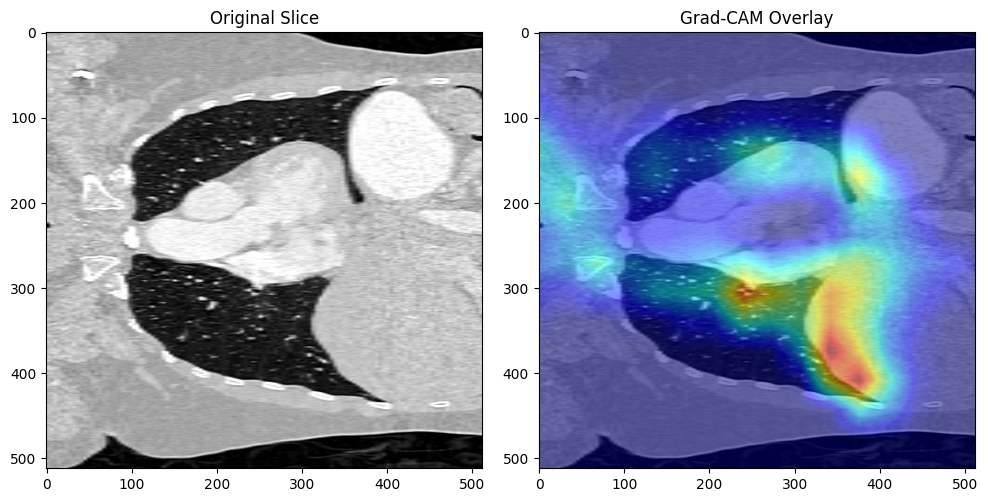

In [31]:
# Choose target layer (last conv in Densenet 3D)
target_layer = model.model.features.norm5

# Initialize GradCAM
grad_cam = GradCAM3D(model, target_layer)

# Run on one sample
image, label = test_dataset[0]  # image should be a tensor
cam, predicted_class = grad_cam.generate(image)

# Show visualization
grad_cam.visualize(image, cam)

Backward hook triggered
Backward hook triggered
Backward hook triggered
Backward hook triggered


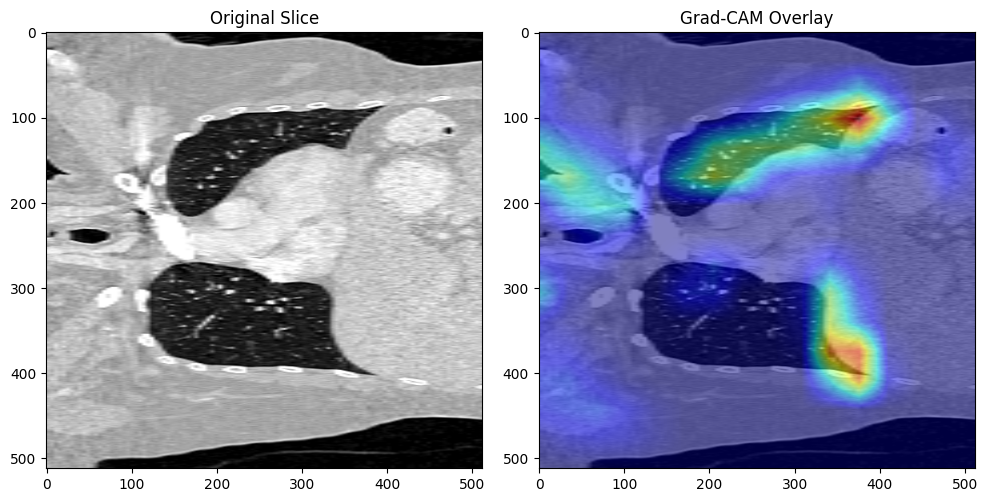

In [47]:
# Choose target layer (last conv in Densenet 3D)
target_layer = model.model.features.norm5

# Initialize GradCAM
grad_cam = GradCAM3D(model, target_layer)

# Run on one sample
image, label = test_dataset[19]  # image should be a tensor
cam, predicted_class = grad_cam.generate(image)

# Show visualization
grad_cam.visualize(image, cam)